In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GroupKFold, cross_validate
from sklearn.gaussian_process.kernels import Matern, RBF

from doc.mse_estimator import ErrorComparer
from spe.data_generation import gen_rbf_X, gen_matern_X, create_clus_split, gen_cov_mat

import matplotlib.pyplot as plt

## Setup

In [122]:
nx = 100
ny = 100

n = nx * ny
p = 5
s = 5

In [123]:
xs = np.linspace(0, 50, nx)
ys = np.linspace(0, 50, ny)
c_x, c_y = np.meshgrid(xs, ys)
c_x = c_x.flatten()
c_y = c_y.flatten()
coord = np.stack([c_x, c_y]).T

In [127]:
Sigma = gen_cov_mat(c_x, c_y, RBF(length_scale=1.))
Chol = np.linalg.cholesky(Sigma + np.eye(n))

In [128]:
Sigma[:10, 0]

array([1.00000000e+00, 8.80259960e-01, 6.00404295e-01, 3.17320791e-01,
       1.29949664e-01, 4.12357303e-02, 1.01389764e-02, 1.93168556e-03,
       2.85167907e-04, 3.26202103e-05])

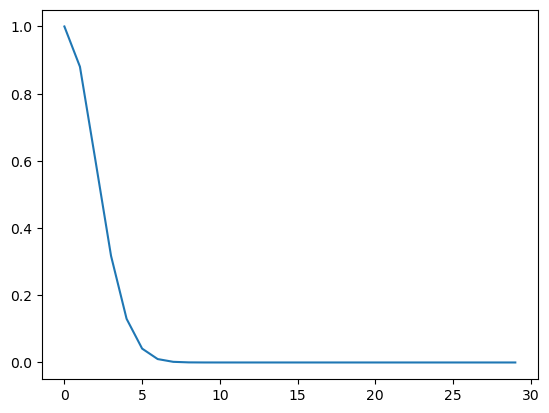

In [129]:
plt.plot(Sigma[:30,0])

## Generate Gaussian X, Y

In [130]:
X = gen_rbf_X(c_x, c_y, p)
# X = gen_matern_X(c_x, c_y, p, length_scale=1, nu=1)
# X = np.random.randn(n,p)

beta = np.zeros(p)
idx = np.random.choice(p,size=s)
beta[idx] = np.random.uniform(-1,1,size=s)

In [131]:
Y = X@beta + Chol @ np.random.randn(n)

In [199]:
tr_idx = np.random.choice(n, size=int(.01*n), replace=False)
tr_bool = np.zeros(n, dtype=bool)
tr_bool[tr_idx] = True

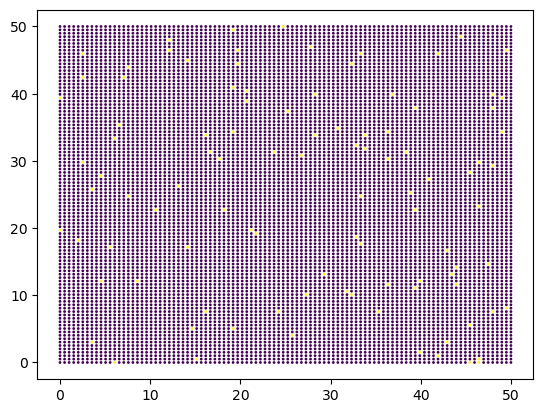

In [200]:
plt.scatter(c_x, c_y, c=tr_bool, label=tr_bool, s=1)


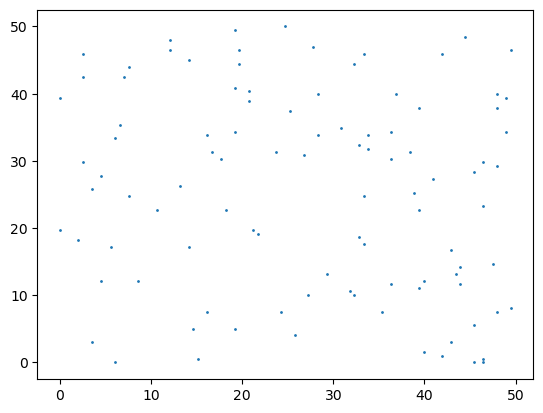

In [201]:
plt.scatter(c_x[tr_bool], c_y[tr_bool], s=1)


In [202]:
D = getDistance(c_x, c_y)

In [203]:
ts_idx = None
for i, truefalse in enumerate(tr_bool):
    if truefalse:
        if ts_idx is None:
            ts_idx = np.where(D[i,:] > 5)[0]
        else:
            ts_idx = np.intersect1d(ts_idx, np.where(D[i,:] > 5)[0])

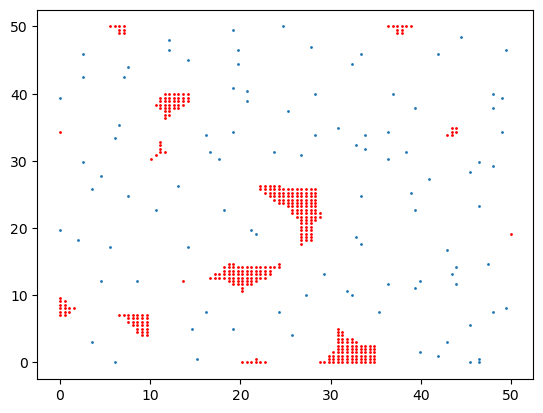

In [204]:
ts_idx = np.unique(ts_idx)
ts_bool = np.zeros_like(c_x).astype(bool)
ts_bool[ts_idx] = True
plt.scatter(c_x[tr_bool], c_y[tr_bool], s=1)
plt.scatter(c_x[ts_bool], c_y[ts_bool], s=1, c='red')

In [138]:
Loc = np.stack([c_x, c_y]).T
m = np.sum(Loc**2, axis=1)
D = (-2 * Loc.dot(Loc.T) + m).T + m
D = 0.5 * (D + D.T)
D = np.maximum(D, 0)  ## sometimes gets values like -1e-9
D = np.sqrt(D)

In [139]:
(D[tr_bool,:][:, ~tr_bool].min(0) > 5).sum(), (D[tr_bool,:][:, ~tr_bool].min(0) > 5).mean()

(656, 0.06626262626262626)

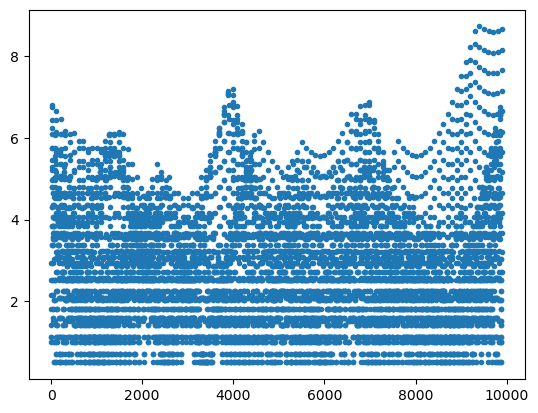

In [140]:
plt.plot(D[tr_bool,:][:, ~tr_bool].min(0), '.')

In [170]:
def getDistance(c_x, c_y):
    Loc = np.stack([c_x, c_y]).T
    m = np.sum(Loc**2, axis=1)
    D = (-2 * Loc.dot(Loc.T) + m).T + m
    D = 0.5 * (D + D.T)
    D = np.maximum(D, 0)  ## sometimes gets values like -1e-9
    D = np.sqrt(D)
    
    return D

def BLOOSplitter(c_x, c_y, d=5):

    D = getDistance(c_x, c_y)
    
    for i in np.arange(len(c_x)):
#         ts_idx = np.zeros((len(c_x),1), dtype=bool)
        ts_idx = i
    
        tr_idx = np.where(D[ts_idx,:] > d)[0]
        yield tr_idx, ts_idx

def BLOOCV(X, y, c_x, c_y):
#     return cross_validate(LinearRegression(), X, y, cv=BLOOSplitter(c_x, c_y), scoring='neg_mean_squared_error')
    m = LinearRegression()
    scores = []
    for tr_idx, ts_idx in BLOOSplitter(c_x, c_y):
        X_tr = X[tr_idx,:]
        y_tr = y[tr_idx]
        
        X_ts = X[ts_idx,:].reshape(1,-1)
        y_ts = y[ts_idx].reshape(1,-1)
        
        m.fit(X_tr, y_tr)
        scores.append((y_ts - m.predict(X_ts))**2)
        
    return np.array(scores)

def ErrXY(X, y, tr_idx, ts_idx=None):
    m = LinearRegression()
    m.fit(X[tr_idx], y[tr_idx])
    if ts_idx is None:
        ts_idx = ~tr_idx
    return np.mean((y[ts_idx] - m.predict(X[ts_idx]))**2)

def ErrX(X, beta, Chol, tr_idx, niter=100):
    errs = np.zeros(niter)
    for i in np.arange(niter):
        Y = X@beta + Chol @ np.random.randn(n)
        errs[i] = ErrXY(X, Y, tr_idx)
    return np.mean(errs)

def AvgErr(c_x, c_y, p, beta, Chol, tr_idx, niter=100):
    errs = np.zeros(niter)
    for i in np.arange(niter):
        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        errs[i] = ErrXY(X, Y, tr_idx)
    return np.mean(errs)

def BuffErr(c_x, c_y, p, beta, Chol, tr_idx, niter=100, d=5):
    D = getDistance(c_x, c_y)
    ts_idx = None
    for j, truefalse in enumerate(tr_idx):
        if truefalse:
            if ts_idx is None:
                ts_idx = np.where(D[j,:] > 5)[0]
            else:
                ts_idx = np.intersect1d(ts_idx, np.where(D[j,:] > 5)[0])
    errs = np.zeros(niter)
    for i in np.arange(niter):
        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        
        errs[i] = ErrXY(X, Y, tr_idx, ts_bool)
    return np.mean(errs)

def BuffErrX(c_x, c_y, X, beta, Chol, tr_idx, niter=100, d=5):
    D = getDistance(c_x, c_y)
    ts_idx = None
    for j, truefalse in enumerate(tr_idx):
        if truefalse:
            if ts_idx is None:
                ts_idx = np.where(D[j,:] > 5)[0]
            else:
                ts_idx = np.intersect1d(ts_idx, np.where(D[j,:] > 5)[0])
    errs = np.zeros(niter)
    for i in np.arange(niter):
        Y = X@beta + Chol @ np.random.randn(n)
        
        errs[i] = ErrXY(X, Y, tr_idx, ts_bool)
    return np.mean(errs)

In [142]:
c_x.shape, tr_bool.shape

((10000,), (10000,))

In [143]:
blcverr = BLOOCV(X[tr_bool], Y[tr_bool], c_x[tr_bool], c_y[tr_bool]).mean()

In [144]:
errxy = ErrXY(X, Y, tr_bool)

In [145]:
errx = ErrX(X, beta, Chol, tr_bool)

In [146]:
avgerr = AvgErr(c_x, c_y, p, beta, Chol, tr_bool, niter=5)

In [147]:
bufferr = BuffErr(c_x, c_y, p, beta, Chol, tr_bool, niter=5)

In [148]:
bufferrX = BuffErrX(c_x, c_y, X, beta, Chol, tr_bool, niter=5)

In [149]:
import timeit

In [150]:
%%timeit
BuffErr(c_x, c_y, p, beta, Chol, tr_bool, niter=1)

2.8 s ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [158]:
%%timeit
BuffErr(c_x, c_y, p, beta, Chol, tr_bool, niter=5)

5.85 s ± 55.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [151]:
%%timeit
AvgErr(c_x, c_y, p, beta, Chol, tr_bool, niter=1)

765 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [160]:
%%timeit
AvgErr(c_x, c_y, p, beta, Chol, tr_bool, niter=5)

3.79 s ± 33.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
%%timeit
BuffErrX(c_x, c_y, X, beta, Chol, tr_bool, niter=1)

2.04 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [159]:
%%timeit
BuffErrX(c_x, c_y, X, beta, Chol, tr_bool, niter=5)

2.06 s ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [153]:
%%timeit
ErrX(X, beta, Chol, tr_bool, niter=1)

9.56 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


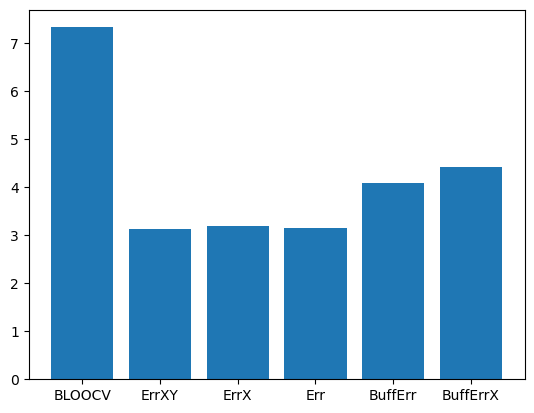

In [108]:
fig, ax = plt.subplots()
ax.bar(x=np.arange(6),height=[blcverr, errxy, errx, avgerr, bufferr, bufferrX])
ax.set_xticks(np.arange(6), labels=['BLOOCV', 'ErrXY', 'ErrX', 'Err', 'BuffErr', 'BuffErrX'])

In [109]:
[blcverr, errxy, errx, avgerr, bufferr, bufferrX]


[7.336192109407038,
 3.1395421924541926,
 3.19220984942754,
 3.1507724688037824,
 4.098498048339065,
 4.434196451748427]

In [205]:
def sim(c_x, c_y, n, p, beta, Chol, nsims=50):
    res = np.zeros((4,nsims))
    
    for i in np.arange(nsims):
        if i % 1 == 0: 
            print(i)
            
        tr_idx = np.random.choice(n, size=int(.01*n), replace=False)
        tr_bool = np.zeros(n, dtype=bool)
        tr_bool[tr_idx] = True

        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        
        res[0,i] = BLOOCV(X[tr_bool], Y[tr_bool], c_x[tr_bool], c_y[tr_bool]).mean()
        print("bloo done")
        res[3,i] = ErrXY(X, Y, tr_bool)
        print("XY done")
        res[2,i] = ErrX(X, beta, Chol, tr_bool)
        print("X done")
#         res[3,i] = AvgErr(c_x, c_y, p, beta, Chol, tr_bool)
#         print("avg done")
#         res[2,i] = BuffErr(c_x, c_y, p, beta, Chol, tr_bool)
#         print("avg buff done")
        res[1,i] = BuffErrX(c_x, c_y, X, beta, Chol, tr_bool)
        print("buff x done")
    return res

In [206]:
res = sim(c_x, c_y, n, p, beta, Chol, 20)

0
bloo done
XY done
X done
buff x done
1
bloo done
XY done
X done
buff x done
2
bloo done
XY done
X done
buff x done
3
bloo done
XY done
X done
buff x done
4
bloo done
XY done
X done
buff x done
5
bloo done
XY done
X done
buff x done
6
bloo done
XY done
X done
buff x done
7
bloo done
XY done
X done
buff x done
8
bloo done
XY done
X done
buff x done
9
bloo done
XY done
X done
buff x done
10
bloo done
XY done
X done
buff x done
11
bloo done
XY done
X done
buff x done
12
bloo done
XY done
X done
buff x done
13
bloo done
XY done
X done
buff x done
14
bloo done
XY done
X done
buff x done
15
bloo done
XY done
X done
buff x done
16
bloo done
XY done
X done
buff x done
17
bloo done
XY done
X done
buff x done
18
bloo done
XY done
X done
buff x done
19
bloo done
XY done
X done
buff x done


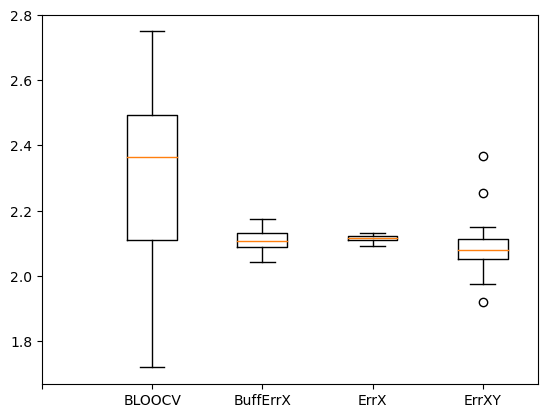

In [207]:
fig, ax = plt.subplots()
ax.boxplot(res.T)
ax.set_xticks(np.arange(5), labels=['', 'BLOOCV', "BuffErrX", 'ErrX', 'ErrXY'])

In [185]:
res.mean(1)

array([2.01015458, 1.9850265 , 1.99384188, 1.97488094])

In [192]:
res

array([[2.05982477, 2.06649188, 2.06548223, 1.88707438, 1.98774832,
        1.96977939, 1.93185488, 1.91418097, 1.9214078 , 1.92632336,
        2.00876134, 2.23252404, 2.04851041, 1.92500497, 1.98876901,
        1.99423104, 2.04180068, 2.17663893, 1.97325064, 2.08343262],
       [1.97610831, 1.97198774, 1.98303056, 1.98988077, 1.97972044,
        1.97810484, 1.96368546, 1.96612329, 1.99954974, 2.00043488,
        2.00233751, 1.98454059, 1.99342478, 1.99024913, 1.96001876,
        2.00180969, 1.98842731, 1.99072559, 1.99453071, 1.98583989],
       [1.99028794, 1.98561139, 1.99296732, 1.99406435, 1.996225  ,
        1.99211636, 1.9901547 , 1.99221505, 2.00009819, 1.99423624,
        2.00350517, 1.99052506, 1.98858331, 2.00407751, 1.98874909,
        1.9911638 , 1.99760201, 2.00509546, 1.99135468, 1.98820502],
       [1.99932862, 1.97707249, 1.97856334, 1.94023432, 1.92483154,
        2.04460609, 1.91569157, 1.90325519, 1.93414089, 1.92901043,
        1.93793059, 1.99306488, 1.97101146, 1